In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import sklearn.preprocessing
import pandas_datareader.data as web
from pandas import Series, DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier


import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import explained_variance_score, confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
%matplotlib inline

start = dt.datetime(2016, 1, 1)
#end = dt.datetime(2019, 1, 11)
end = dt.datetime.today()

# Only thing you should set
ticker = 'LMT'

df = web.DataReader(ticker, 'yahoo', start, end)  # Pick ticker symbol
df.tail()  # Show the last 5

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-14,385.369995,381.390015,382.769989,382.609985,622300.0,382.609985
2019-10-15,385.700012,382.070007,383.690002,382.750000,835300.0,382.750000
2019-10-16,384.390015,380.230011,382.390015,382.839996,851300.0,382.839996
2019-10-17,384.209991,376.290009,383.549988,377.059998,1004600.0,377.059998
2019-10-18,377.709991,369.510010,376.720001,370.929993,563451.0,370.929993


In [2]:
# Lets check some stats on our DF
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,956.000000,956.000000,956.000000,956.000000,9.560000e+02,956.000000
mean,296.529644,292.057594,294.401182,294.353797,1.429104e+06,281.615404
std,46.045133,45.037255,45.668894,45.511962,1.156691e+06,50.367242
min,209.429993,200.470001,201.429993,206.080002,3.209000e+05,186.793137
25%,257.907501,254.715000,256.800003,256.640007,9.034000e+05,237.951206
50%,302.290009,297.279999,300.000000,299.440002,1.148900e+06,289.295898
75%,328.667488,322.577507,325.597496,325.290001,1.508650e+06,313.867378
max,399.959991,393.029999,397.140015,397.040009,1.396230e+07,397.040009


(45, 60)

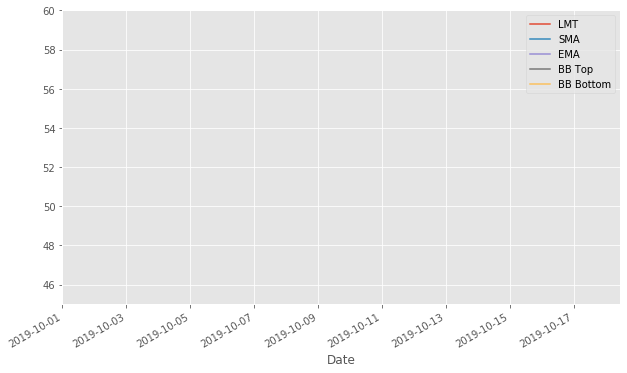

In [3]:
# Simple Moving Average

close_px = df['Adj Close']

window = 10  # set window here

#Simple Moving Average
sma = close_px.rolling(window=window).mean()

#Moving Standard Deviation
msd = close_px.rolling(window=window).std()

#Bollinger Bands
topBand = sma + (2 * msd)
bottomBand = sma - (2 * msd)

#Exponential Moving Average
ema = close_px.ewm(span=window, adjust=False).mean()


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(10, 6))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label=ticker)
sma.plot(label='SMA')
sma.plot(label='EMA')
topBand.plot(label='BB Top')
bottomBand.plot(label='BB Bottom')
plt.legend()
plt.xlim([dt.date(2019, 10, 1), end])
plt.ylim(45, 60)  # Use for zooming in

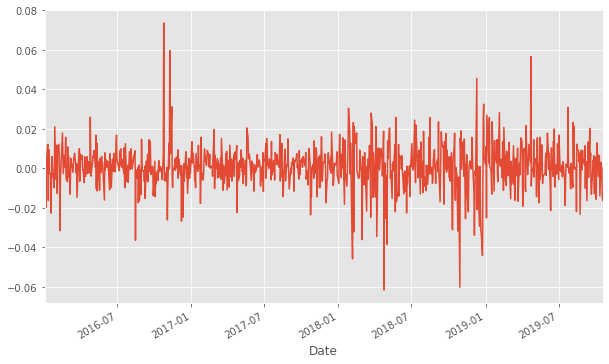

In [4]:
# Risk and Return Deviation
# Risk adverse --> lower drop is better
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

Text(0, 0.5, 'Returns DIS')

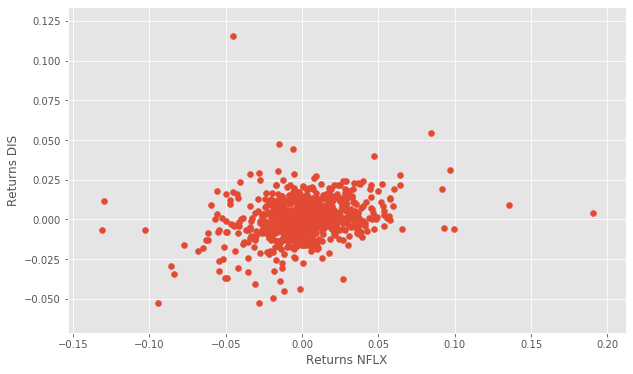

In [5]:
# Lets look at competitors to Ticker selected
# Correlation analysis - Check for positive - whole industry benefits - Negative - Neutral
dfcomp = web.DataReader(['DIS', 'AAPL', 'AMZN', 'NFLX'],'yahoo',start=start,end=end)['Adj Close']
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
plt.scatter(retscomp.NFLX, retscomp.DIS)
plt.xlabel('Returns NFLX')
plt.ylabel('Returns DIS')

In [6]:
# Lets do some price predicting using ML
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-10-14,382.609985,622300.0,1.040219,-0.041802
2019-10-15,382.750000,835300.0,0.948401,-0.244990
2019-10-16,382.839996,851300.0,1.086617,0.117676
2019-10-17,377.059998,1004600.0,2.100457,-1.692085
2019-10-18,370.929993,563451.0,2.210655,-1.536953


In [7]:
# Preprocessing so the model works
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = sklearn.preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
xLately = X[-forecast_out:]
xTrain = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
yTrain = y[:-forecast_out]
#dfreg.tail()

In [8]:
# Learning Models
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(xTrain, yTrain)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(xTrain, yTrain)
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(xTrain, yTrain)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [9]:
params = {"algorithm": ['ball_tree', 'kd_tree', 'brute'],
          "leaf_size": [10, 20, 30, 40],
          "metric": ['minkowski', 'manhattan'],
          "weights": ['uniform', 'distance'],
          "n_neighbors": [5, 7, 10, 12, 15, 20],}

grid_search = GridSearchCV(KNeighborsRegressor(), params, cv=5, n_jobs=-1)

In [10]:
grid_search.fit(xTrain, yTrain)

/Users/B/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40],
                         'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [5, 7, 10, 12, 15, 20],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [11]:
grid_search.best_params_

{'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 10,
 'weights': 'distance'}

In [12]:
# KNN Regression With Best Params
knn = KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')
knn.fit(xTrain, yTrain)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=1, n_neighbors=10, p=2,
                    weights='distance')

[379.86936019 381.93882143 379.19264051 383.05588032 379.78404731
 378.26529733 380.32587409 383.93689381 375.87724469 373.34806125]


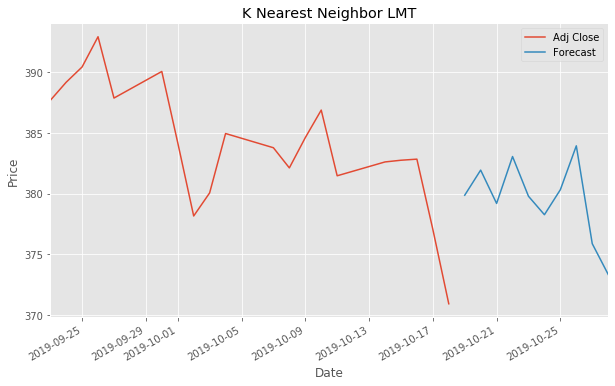

In [13]:
#Plot the Forecast
forecast_set = knn.predict(xLately)
dfreg['Forecast'] = np.nan
print(forecast_set)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(30).plot()
dfreg['Forecast'].tail(30).plot()
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('K Nearest Neighbor {}'.format(ticker))
plt.show()

[383.88614869 382.54370637 384.88605151 387.43918195 381.94735365
 383.10890438 382.83544207 383.01003896 377.86470886 372.66249091]


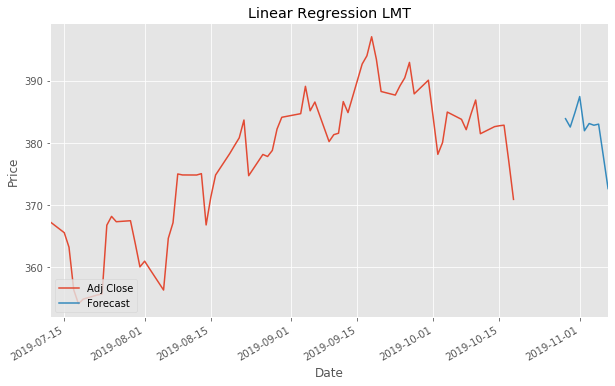

In [14]:
forecast_set = clfreg.predict(xLately)
dfreg['Forecast'] = np.nan
print(forecast_set)
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(90).plot()
dfreg['Forecast'].tail(90).plot()
plt.legend(loc=3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear Regression {}'.format(ticker))
plt.show()

[383.57540011 381.76082943 384.46620051 386.576458   380.62498095
 382.65922759 382.59377324 382.49540794 376.88887224 371.31347061]


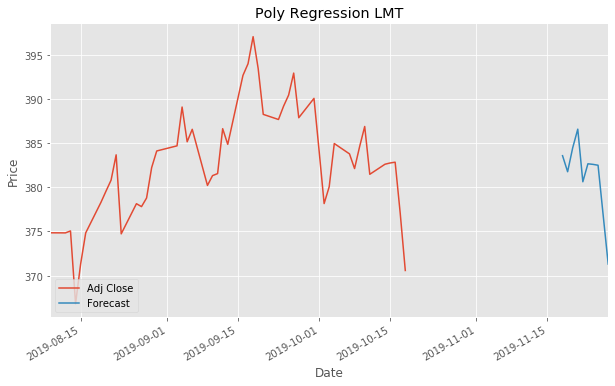

In [17]:
forecast_set = clfpoly2.predict(xLately)
dfreg['Forecast'] = np.nan
print(forecast_set)
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(90).plot()
dfreg['Forecast'].tail(90).plot()
plt.legend(loc=3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Poly Regression {}'.format(ticker))
plt.show()